# **`Chat bot with Multiple Tool Calls`**

# we integrate arxiv and wikipedia with our ChatBot

In [2]:
from langchain_community.tools import ArxivQueryRun , WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper , ArxivAPIWrapper # for running queries 


In [6]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2 , doc_content_chars_max=5000)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)

In [7]:
print(arxiv.name)

arxiv


In [8]:
arxiv.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time on the performance of\nLlama-v2 models. We find that dropping dreeper attention layers only marginally\ndecreases performance but leads to the best speedups alongside dropping entire\nlayers. For example, removing 33\\% of attention layers in a 13B Llama2 model\nresults in a 1.8\\% drop in average performance over the OpenLLM benchmark. We\nalso observe that skipping layers except the latter layers reduces performances\nfor more layers skipped, except for skipping the attention layers.\n\n

In [9]:
api_wrapper_wikipedia = WikipediaAPIWrapper(top_k_results=2 , doc_content_chars_max=500)
wikipedia = WikipediaQueryRun(api_wrapper=api_wrapper_wikipedia)

In [11]:
wikipedia.invoke("Who is Maulana Moududi")

'Page: Abul A\'la Maududi\nSummary: Abul A\'la al-Maududi (Urdu: ابو الاعلیٰ المودودی, romanized: Abū al-Aʿlā al-Mawdūdī; (1903-09-25)25 September 1903 – (1979-09-22)22 September 1979) was an Islamic scholar, Islamist ideologue, Muslim philosopher, jurist, historian, journalist, activist, and scholar active in British India and later, following the partition, in Pakistan. Described by Wilfred Cantwell Smith as "the most systematic thinker of modern Islam", his numerous works, which "covered a range '

In [13]:
# setup of API keys
from dotenv import load_dotenv
load_dotenv()
import os 
os.environ['TAVILY_API_KEY'] = os.getenv("TAVILY_API_KEY")
os.environ['GROQ_API_KEY'] = os.getenv("GROQ_API_KEY")


In [15]:
from langchain_community.tools.tavily_search import TavilySearchResults
tavily = TavilySearchResults()

In [ ]:
results = tavily.invoke('What is the current AI News')

[{'title': 'The latest AI news we announced in June - Google Blog',
  'url': 'https://blog.google/technology/ai/google-ai-updates-june-2025/',
  'content': '# The latest AI news we announced in June\n\nJul 02, 2025\n\nHere’s a recap of some of our biggest AI updates from June, including more ways to search with AI Mode, a new way to share your NotebookLM notebooks publicly, and a new AI to help researchers better understand the human genome.\n\nSuperG\n\n## Basic explainer [...] Search finds new voice, and photos bright,  \nWhile Chromebooks gain AI\'s keenest edge,  \nAnd learning\'s path is filled with light.\n\nGenomes unlock, from knowledge pledge,  \nAnd robots learn, with vision clear,  \nWhile cancer\'s foe meets AI\'s siege.\n\nFrom Google\'s labs, new AI doth spring,  \nWith Gemini\'s models taking flight,  \nAnd tools for coders, joy to bring.\n\nSearch finds new voice, and photos bright,  \nWhile Chromebooks gain AI\'s keenest edge,  \nAnd learning\'s path is filled with lig

In [27]:
results = tavily.invoke('What is the current AI News for july 17 2025')

In [ ]:
results[2]


dict

In [29]:
from pprint import pprint
for i in range(len(results)):
    print(f"******************************** NEWS {i+1} ************************************")
    print(results[i]['content'])
    print('\n')

******************************** NEWS 1 ************************************
From personalized healthcare to automated investing, AI has the potential to revolutionize nearly every aspect of business.


******************************** NEWS 2 ************************************
The idea was to sell Chinese businesses Nvidia's fourth-best chip, he said, so that “they get addicted to the American technology stack.” Days


******************************** NEWS 3 ************************************
Wall Street giants are purchasing utilities amid the ongoing AI boom to benefit from the rising demand for electricity from data centers.


******************************** NEWS 4 ************************************
AI is also helping expand into global markets through automated multilingual outputs. Experts say the tech is reshaping how content is created and distributed.


******************************** NEWS 5 ************************************
July 17, 2025. Artificial intelligence has

In [30]:
tools = [arxiv , wikipedia , tavily]

In [35]:
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage , AIMessage , AnyMessage
model = ChatGroq(model="qwen/qwen3-32b")

In [37]:
llm_with_tool = model.bind_tools(tools)
llm_with_tool.invoke([HumanMessage(content="What is the recent AI news")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent AI news'},
  'id': 'j71947kcn',
  'type': 'tool_call'}]

In [50]:
from typing import TypedDict , Annotated
from langgraph.graph.message import add_messages
class State(TypedDict):
    
    messages : Annotated[list[AnyMessage] , add_messages]

In [51]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode , tools_condition

### Node Definition
def tool_calling_llm(state:State):
    return {"messages" : [llm_with_tool.invoke(state['messages'])]}

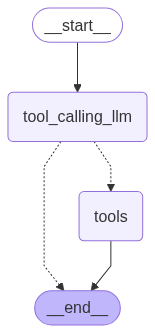

In [52]:
builder = StateGraph(State)
builder.add_node('tool_calling_llm' , tool_calling_llm)
builder.add_node('tools' , ToolNode(tools))

## Defining the Workflow
builder.add_edge(START , 'tool_calling_llm')
builder.add_conditional_edges(
    'tool_calling_llm',
    tools_condition
)
builder.add_edge('tools' , END)

graph =builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [61]:
from pprint import pprint
messages = graph.invoke({"messages" : HumanMessage(content="what is the recent AI advancement in Meta")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

what is the recent AI advancement in Meta
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (2qejrnysf)
 Call ID: 2qejrnysf
  Args:
    query: recent AI advancements in Meta 2023-2024
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Connect 2024: The responsible approach we're taking to generative AI", "url": "https://ai.meta.com/blog/responsible-ai-connect-2024/", "content": "Today at Connect 2024, we shared updates for Meta AI features and released Llama 3.2, a collection of models that includes new vision capabilities as well as lightweight models that can fit on mobile devices. With the rapidly evolving AI landscape, we recognize the importance of sharing our responsibility and safety approach with everyone—whether you’re a developer building with Llama 

In [62]:
from pprint import pprint
messages = graph.invoke({"messages" : HumanMessage(content="1706.03762")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (34d95xh76)
 Call ID: 34d95xh76
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks in an encoder-decoder configuration. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer, based
solely on attention mechanisms, dispensing with recurrence and convolutions
entirely. Experiments on two machine translation tasks show these models